In [5]:
!pip install imageio
!pip install scikit-image

  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 29.1 MB/s  0:00:00m0:00:010:01
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-image] [scikit-image]


In [4]:
import os
import pandas as pd
import imageio.v2 as imageio
import re
from skimage import measure

# --- CONFIGURATION ---
# Root directory on your hard drive containing the Plate folders
#root_dir = "/media/arnout/Elements/Thesis/Screen crispri quality checked"
root_dir = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset/inputs/images"
# Destination for location CSVs on your hard drive
loc_dir = "/media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset/inputs/locations/PLATE1_T2"

os.makedirs(loc_dir, exist_ok=True)

# Minimum pixel area for a bacterium to be included
MIN_AREA_THRESHOLD = 800 

# Regex specifically looks for the C1 mask to use as the reference for the site
mask_pattern = re.compile(r"Sample_(?P<well>[A-Z][0-9]+)_XY(?P<site>[0-9]+)_C1_cp_masks\.tif+")

print(f"Scanning root directory: {root_dir}")
print(f"Generating location files (Reference: C1, Min Area: {MIN_AREA_THRESHOLD})")

found_count = 0

for plate in os.listdir(root_dir):
    if not plate.startswith("PLATE"): continue
    plate_path = os.path.join(root_dir, plate)
    
    for well_folder in os.listdir(plate_path):
        if not well_folder.startswith("Sample_") or "bad_Q" in well_folder: continue
        mask_folder = os.path.join(plate_path, well_folder, "masks")
        
        if os.path.exists(mask_folder):
            for mask_name in os.listdir(mask_folder):
                match = mask_pattern.search(mask_name)
                
                if match:
                    well = match.group('well')
                    site = match.group('site')
                    # DeepProfiler Format: Well-Site-Nuclei.csv (e.g., A1-0-Nuclei.csv)
                    out_filename = f"{well}-{site}-Nuclei.csv"
                    
                    path = os.path.join(mask_folder, mask_name)
                    mask_data = imageio.imread(path)
                    props = measure.regionprops(mask_data)
                    
                    locations = []
                    for p in props:
                        if p.area >= MIN_AREA_THRESHOLD:
                            locations.append({
                                "Nuclei_Location_Center_X": p.centroid[1], 
                                "Nuclei_Location_Center_Y": p.centroid[0]
                            })
                    
                    if locations:
                        df = pd.DataFrame(locations)
                        df.to_csv(os.path.join(loc_dir, out_filename), index=False)
                        found_count += 1
                        print(f"  > Created {out_filename} ({len(locations)} bacteria)")

print(f"\nSuccess! Generated {found_count} location files in: {loc_dir}")

Scanning root directory: /media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset/inputs/images
Generating location files (Reference: C1, Min Area: 800)
  > Created A1-0-Nuclei.csv (15 bacteria)
  > Created A1-1-Nuclei.csv (7 bacteria)
  > Created B11-4-Nuclei.csv (213 bacteria)
  > Created B11-5-Nuclei.csv (194 bacteria)
  > Created C2-10-Nuclei.csv (32 bacteria)
  > Created C2-9-Nuclei.csv (5 bacteria)
  > Created D11-0-Nuclei.csv (550 bacteria)
  > Created D11-1-Nuclei.csv (614 bacteria)
  > Created E11-0-Nuclei.csv (206 bacteria)
  > Created E11-1-Nuclei.csv (711 bacteria)

Success! Generated 10 location files in: /media/arnout/Elements1/groteEdeepprofilerdingen/deepprofileroutputsetc/testset/inputs/locations/PLATE1_T2


In [10]:
#moving masks
import os
import shutil

# --- CONFIGURATION ---
# Root directory on your hard drive containing the Plate folders
root_dir = "/media/arnout/Elements/Thesis/Screen crispri quality checked"

# Destination for all masks (the flat folder)
outlines_dest = "/media/arnout/Elements/Thesis/DeepProfiler_Inputs/outlines"

os.makedirs(outlines_dest, exist_ok=True)

print(f"Flattening masks from: {root_dir}")
print(f"Target directory: {outlines_dest}")

count = 0

for plate in os.listdir(root_dir):
    if not plate.startswith("PLATE"): 
        continue
    plate_path = os.path.join(root_dir, plate)
    
    for well_folder in os.listdir(plate_path):
        if not well_folder.startswith("Sample_") or "bad_Q" in well_folder: 
            continue
        
        mask_source_folder = os.path.join(plate_path, well_folder, "masks")
        
        if os.path.exists(mask_source_folder):
            for mask_file in os.listdir(mask_source_folder):
                if mask_file.endswith(".tif") or mask_file.endswith(".tiff"):
                    source_file = os.path.join(mask_source_folder, mask_file)
                    destination_file = os.path.join(outlines_dest, mask_file)
                    
                    # shutil.copy2 preserves metadata (timestamps, etc.)
                    shutil.copy2(source_file, destination_file)
                    count += 1

print(f"\nSuccess! Moved {count} masks to {outlines_dest}")

Flattening masks from: /media/arnout/Elements/Thesis/Screen crispri quality checked
Target directory: /media/arnout/Elements/Thesis/DeepProfiler_Inputs/outlines

Success! Moved 1164 masks to /media/arnout/Elements/Thesis/DeepProfiler_Inputs/outlines


In [11]:
import os
import shutil

# --- CONFIGURATION ---
# Root directory on your hard drive containing the Plate folders
root_dir = "/media/arnout/Elements/Thesis/Screen crispri quality checked"

# Destination for all masks (the flat folder on your hard drive)
outlines_dest = "/media/arnout/Elements/Thesis/DeepProfiler_Inputs/outlines"

os.makedirs(outlines_dest, exist_ok=True)

print(f"Moving masks from: {root_dir}")
print(f"To flat directory: {outlines_dest}")

count = 0

for plate in os.listdir(root_dir):
    if not plate.startswith("PLATE"): 
        continue
    plate_path = os.path.join(root_dir, plate)
    
    for well_folder in os.listdir(plate_path):
        if not well_folder.startswith("Sample_") or "bad_Q" in well_folder: 
            continue
        
        mask_source_folder = os.path.join(plate_path, well_folder, "masks")
        
        if os.path.exists(mask_source_folder):
            for mask_file in os.listdir(mask_source_folder):
                if mask_file.endswith(".tif") or mask_file.endswith(".tiff"):
                    source_path = os.path.join(mask_source_folder, mask_file)
                    destination_path = os.path.join(outlines_dest, mask_file)
                    
                    # shutil.move physically moves the file
                    shutil.move(source_path, destination_path)
                    count += 1
            
            # Optional: Remove the now-empty 'masks' folder to clean up
            try:
                os.rmdir(mask_source_folder)
            except OSError:
                # Folder might not be empty if there are non-tiff files
                pass

print(f"\nSuccess! Moved {count} masks. The 'masks' subfolders have been removed.")

Moving masks from: /media/arnout/Elements/Thesis/Screen crispri quality checked
To flat directory: /media/arnout/Elements/Thesis/DeepProfiler_Inputs/outlines

Success! Moved 1164 masks. The 'masks' subfolders have been removed.


In [12]:
#nu location ding geupdate naar nieuwe mask folder
import os
import pandas as pd
import imageio.v2 as imageio
import re
from skimage import measure

# --- CONFIGURATION ---
# The new flat folder where you moved all the masks
mask_dir = "/media/arnout/Elements/Thesis/DeepProfiler_Inputs/outlines"

# Where to save the location CSVs (Stay on hard drive)
loc_dir = "/media/arnout/Elements/Thesis/DeepProfiler_Inputs/locations/MutantStudy"

os.makedirs(loc_dir, exist_ok=True)

# Minimum pixel area threshold
MIN_AREA_THRESHOLD = 800 

# Regex looks for the C1 mask as the reference
mask_pattern = re.compile(r"Sample_(?P<well>[A-Z][0-9]+)_XY(?P<site>[0-9]+)_C1_cp_masks\.tif+")

print(f"Processing masks from: {mask_dir}")

found_count = 0

for mask_name in os.listdir(mask_dir):
    match = mask_pattern.search(mask_name)
    
    if match:
        well = match.group('well')
        site = match.group('site')
        out_filename = f"{well}-{site}-Nuclei.csv"
        
        path = os.path.join(mask_dir, mask_name)
        mask_data = imageio.imread(path)
        props = measure.regionprops(mask_data)
        
        locations = []
        for p in props:
            if p.area >= MIN_AREA_THRESHOLD:
                locations.append({
                    "Nuclei_Location_Center_X": p.centroid[1], 
                    "Nuclei_Location_Center_Y": p.centroid[0]
                })
        
        if locations:
            df = pd.DataFrame(locations)
            df.to_csv(os.path.join(loc_dir, out_filename), index=False)
            found_count += 1

print(f"\nSuccess! Generated {found_count} location files.")

Processing masks from: /media/arnout/Elements/Thesis/DeepProfiler_Inputs/outlines

Success! Generated 1162 location files.


Inspecting A1 Site 0
Found 15 objects in location file.


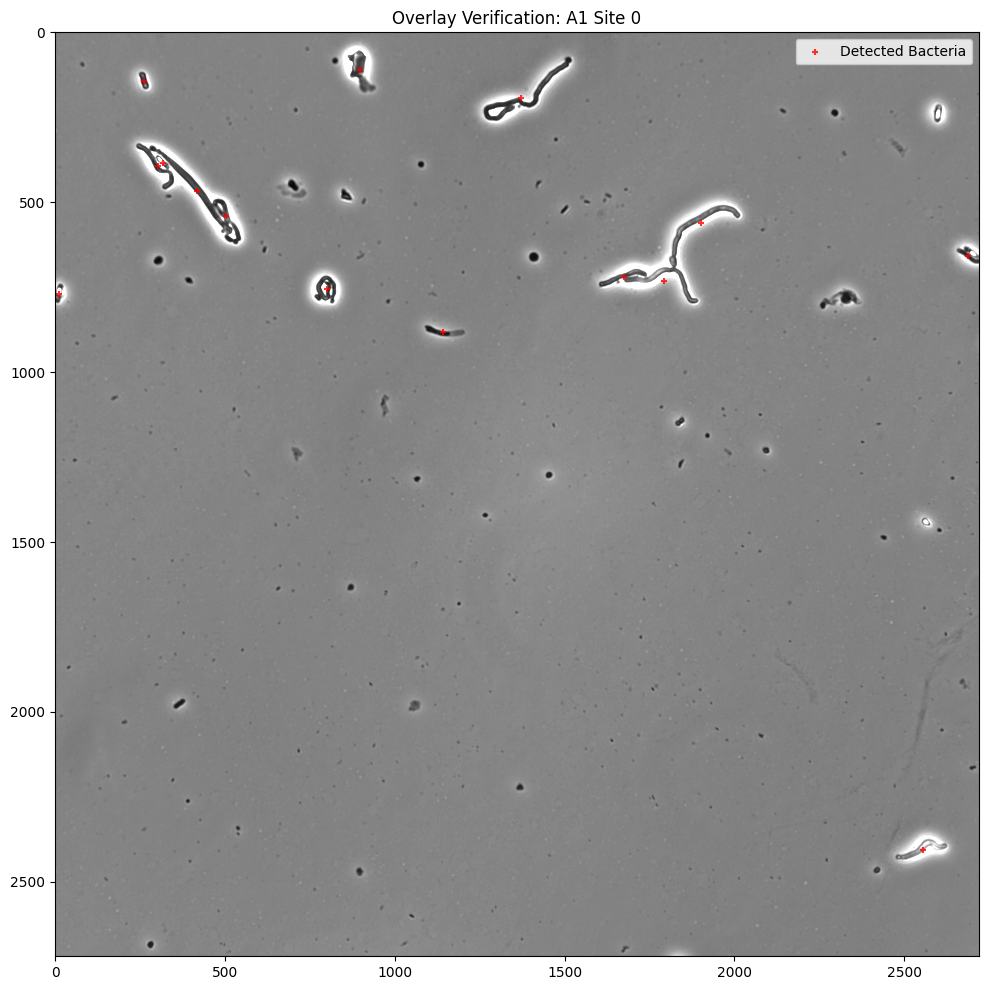

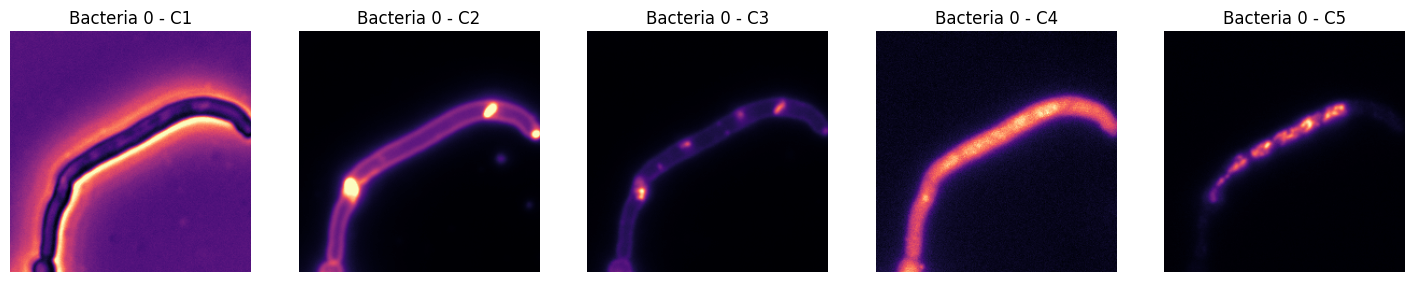

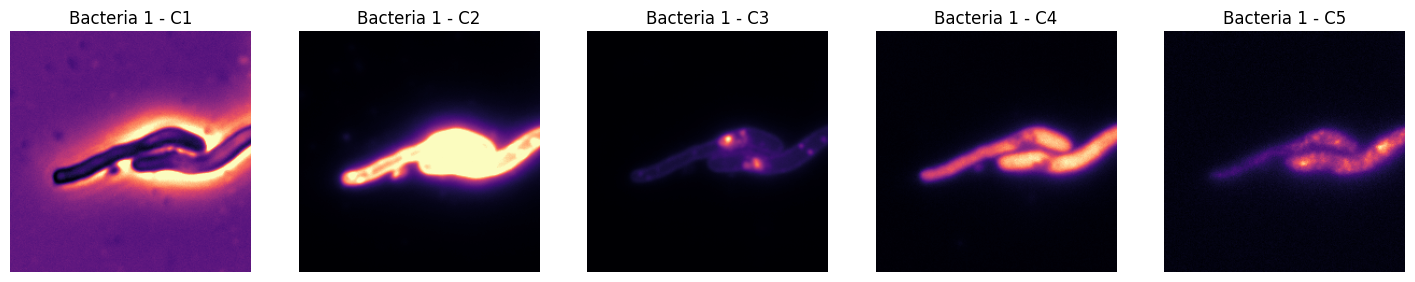

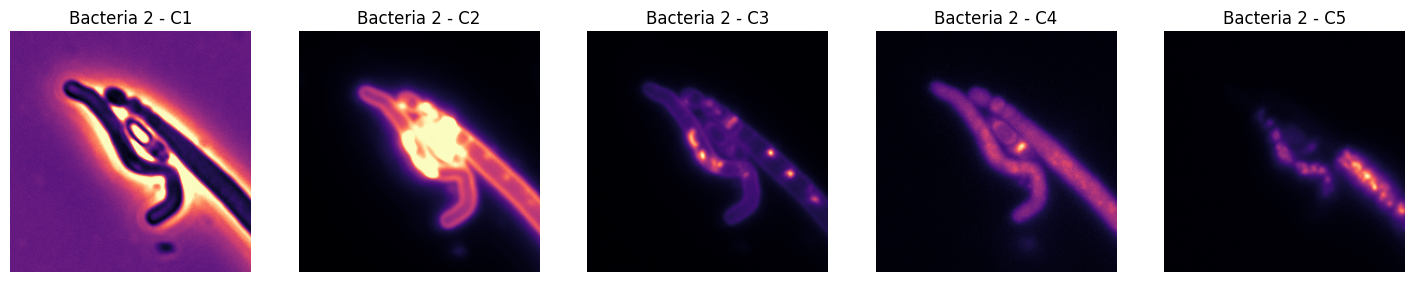

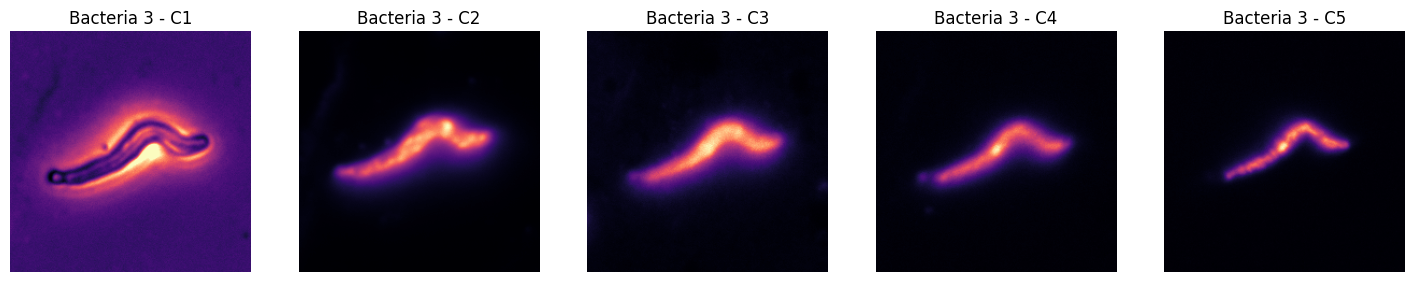

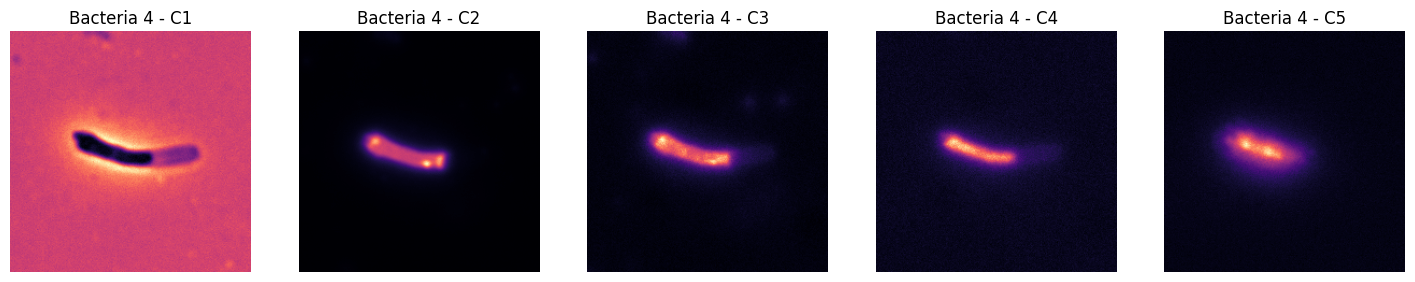

In [2]:
#check juist center profiling zegt idd 15 cells dus ok:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import os

# --- NEW CONFIGURATION (HARD DRIVE) ---
# Location of your generated CSVs
loc_dir = "/media/arnout/Elements/Thesis/my_dp_project (Copy)/inputs/locations/PLATE1_T2"
# Location of your raw images (via the symlink or direct path)
image_dir = "/media/arnout/Elements/Thesis/Screen crispri quality checked"
# Your index file
index_meta_path = "/media/arnout/Elements/Thesis/my_dp_project (Copy)/inputs/metadata/index.csv"

# 1. Pick a specific Well and Site to inspect
target_well = "A1"
target_site = 0

# 2. Load the index to find the image paths
idx_df = pd.read_csv(index_meta_path)
row = idx_df[(idx_df['Metadata_Well'] == target_well) & (idx_df['Metadata_Site'] == target_site)].iloc[0]

# 3. Load the coordinates directly from your new location file
loc_file = os.path.join(loc_dir, f"{target_well}-{target_site}-Nuclei.csv")
site_data = pd.read_csv(loc_file)

print(f"Inspecting {target_well} Site {target_site}")
print(f"Found {len(site_data)} objects in location file.")

# --- PART A: FULL IMAGE OVERLAY ---
c1_path = os.path.join(image_dir, row['C1'])
img_c1 = skimage.io.imread(c1_path)

plt.figure(figsize=(12, 12))
vmax = np.percentile(img_c1, 99.5)  # Contrast stretch
plt.imshow(img_c1, cmap='gray', vmax=vmax)
plt.scatter(site_data['Nuclei_Location_Center_X'], 
            site_data['Nuclei_Location_Center_Y'], 
            s=20, c='red', marker='+', alpha=0.8, label='Detected Bacteria')
plt.title(f"Overlay Verification: {target_well} Site {target_site}")
plt.legend()
plt.show()

# --- PART B: INDIVIDUAL CROPS ---
# View 5 random bacteria to check centering
sample_cells = site_data.sample(5)
box_size = 224 # DeepProfiler uses 224 in your config
half_box = box_size // 2

for i, (_, cell) in enumerate(sample_cells.iterrows()):
    cx, cy = int(cell['Nuclei_Location_Center_X']), int(cell['Nuclei_Location_Center_Y'])
    
    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    channels = ['C1', 'C2', 'C3', 'C4', 'C5']
    
    for j, ch_key in enumerate(channels):
        ch_full = skimage.io.imread(os.path.join(image_dir, row[ch_key]))
        
        # Crop with bounds checking
        y1, y2 = max(0, cy-half_box), min(ch_full.shape[0], cy+half_box)
        x1, x2 = max(0, cx-half_box), min(ch_full.shape[1], cx+half_box)
        crop = ch_full[y1:y2, x1:x2]
        
        axes[j].imshow(crop, cmap='magma')
        axes[j].set_title(f"Bacteria {i} - {ch_key}")
        axes[j].axis('off')
    plt.show()

Inspecting G10 Site 9
Found 533 objects in location file.


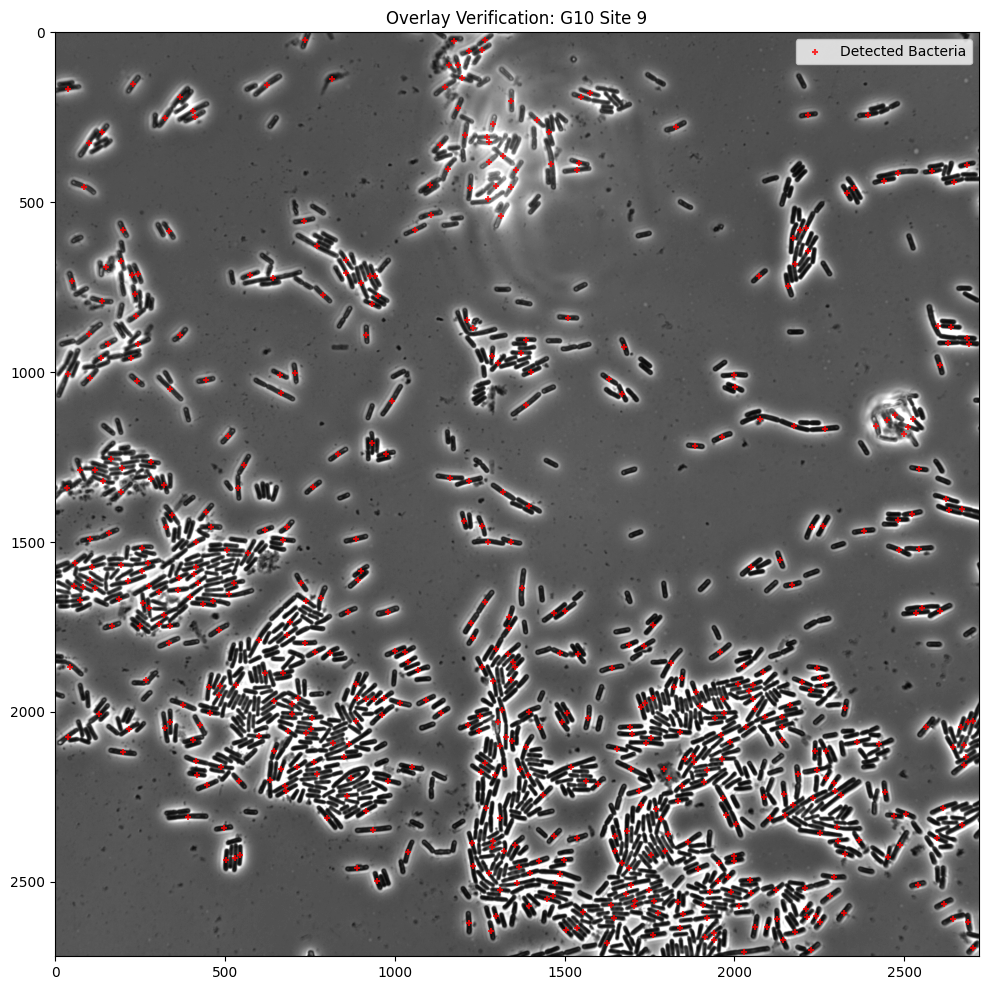

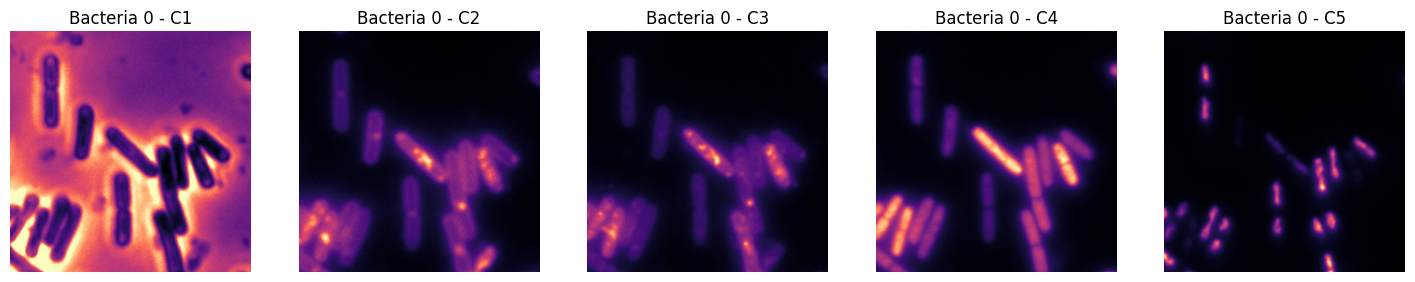

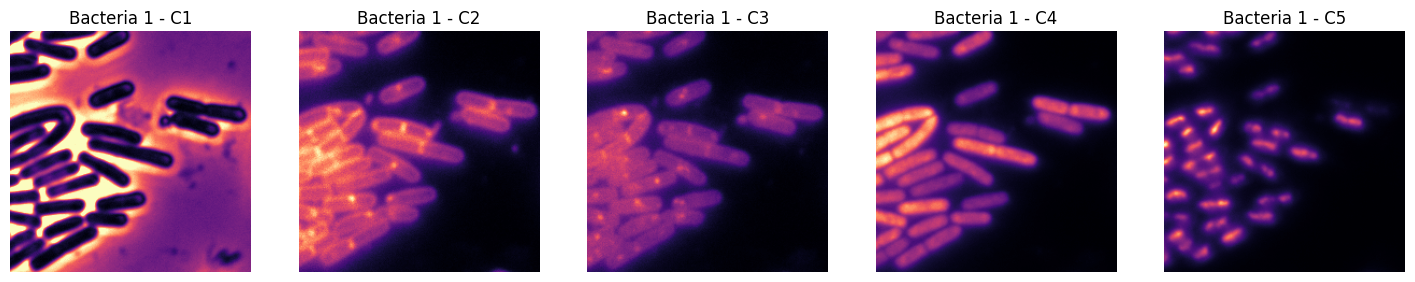

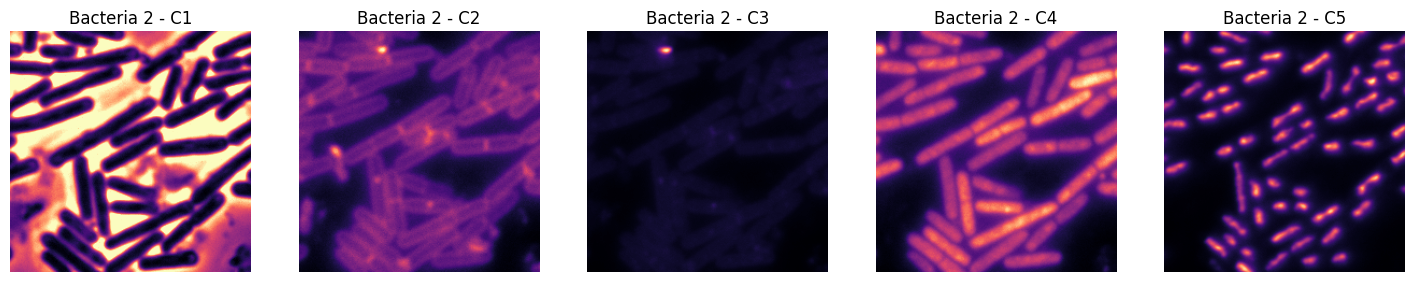

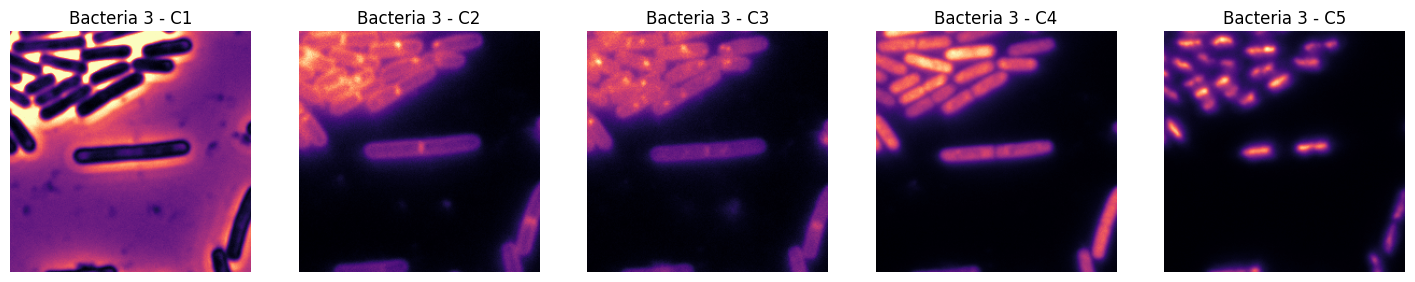

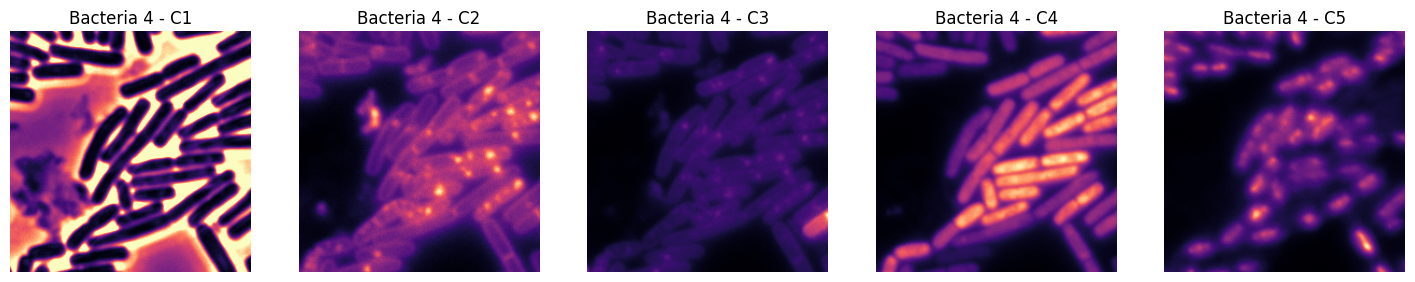

In [5]:
#check juist center:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import os

# --- NEW CONFIGURATION (HARD DRIVE) ---
# Location of your generated CSVs
loc_dir = "/media/arnout/Elements/Thesis/my_dp_project (Copy)/inputs/locations/PLATE1_T2"
# Location of your raw images (via the symlink or direct path)
image_dir = "/media/arnout/Elements/Thesis/Screen crispri quality checked"
# Your index file
index_meta_path = "/media/arnout/Elements/Thesis/my_dp_project (Copy)/inputs/metadata/index.csv"

# 1. Pick a specific Well and Site to inspect
target_well = "G10"        #profiing zet 638 cells
target_site = 9

# 2. Load the index to find the image paths
idx_df = pd.read_csv(index_meta_path)
row = idx_df[(idx_df['Metadata_Well'] == target_well) & (idx_df['Metadata_Site'] == target_site)].iloc[0]

# 3. Load the coordinates directly from your new location file
loc_file = os.path.join(loc_dir, f"{target_well}-{target_site}-Nuclei.csv")
site_data = pd.read_csv(loc_file)

print(f"Inspecting {target_well} Site {target_site}")
print(f"Found {len(site_data)} objects in location file.")

# --- PART A: FULL IMAGE OVERLAY ---
c1_path = os.path.join(image_dir, row['C1'])
img_c1 = skimage.io.imread(c1_path)

plt.figure(figsize=(12, 12))
vmax = np.percentile(img_c1, 99.5)  # Contrast stretch
plt.imshow(img_c1, cmap='gray', vmax=vmax)
plt.scatter(site_data['Nuclei_Location_Center_X'], 
            site_data['Nuclei_Location_Center_Y'], 
            s=20, c='red', marker='+', alpha=0.8, label='Detected Bacteria')
plt.title(f"Overlay Verification: {target_well} Site {target_site}")
plt.legend()
plt.show()

# --- PART B: INDIVIDUAL CROPS ---
# View 5 random bacteria to check centering
sample_cells = site_data.sample(5)
box_size = 224 # DeepProfiler uses 224 in your config
half_box = box_size // 2

for i, (_, cell) in enumerate(sample_cells.iterrows()):
    cx, cy = int(cell['Nuclei_Location_Center_X']), int(cell['Nuclei_Location_Center_Y'])
    
    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    channels = ['C1', 'C2', 'C3', 'C4', 'C5']
    
    for j, ch_key in enumerate(channels):
        ch_full = skimage.io.imread(os.path.join(image_dir, row[ch_key]))
        
        # Crop with bounds checking
        y1, y2 = max(0, cy-half_box), min(ch_full.shape[0], cy+half_box)
        x1, x2 = max(0, cx-half_box), min(ch_full.shape[1], cx+half_box)
        crop = ch_full[y1:y2, x1:x2]
        
        axes[j].imshow(crop, cmap='magma')
        axes[j].set_title(f"Bacteria {i} - {ch_key}")
        axes[j].axis('off')
    plt.show()